# Import the Libraries

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime
import inflection
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
from sklearn.impute import KNNImputer
import statsmodels.api as sm
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen 
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15.7,6.27)})

# Load the dataset

In [2]:
df_sales_raw=pd.read_csv('train.csv')
df_store_raw=pd.read_csv('store.csv')
#Load the dataset

In [3]:
# Let's merge the dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data preparation & understanding

In [4]:
#Copy dataset
df_new = df_raw.copy()
df_new.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Let raname the columns
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map( snakecase, old_columns ) )


#Rename Columns
df_new.columns = new_columns

In [6]:
df_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [7]:
#Let's check the shape of dataset
df_new.shape

(1017209, 18)

In [8]:
df_new[df_new['store']==13].head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
1127,13,4,2015-07-30,7648,474,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
2242,13,3,2015-07-29,6648,406,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
3357,13,2,2015-07-28,6819,446,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
4472,13,1,2015-07-27,7926,527,1,1,0,0,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [9]:
#Store_13
df_new_store13=df_new[df_new['store']==13]

In [10]:
# transform datatype of the variable data to datetime
df_new_store13['date'] = pd.to_datetime( df_new_store13['date'])

In [11]:
df_new_store13.info()
#Let's check the info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 12 to 1016107
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   store                         758 non-null    int64         
 1   day_of_week                   758 non-null    int64         
 2   date                          758 non-null    datetime64[ns]
 3   sales                         758 non-null    int64         
 4   customers                     758 non-null    int64         
 5   open                          758 non-null    int64         
 6   promo                         758 non-null    int64         
 7   state_holiday                 758 non-null    object        
 8   school_holiday                758 non-null    int64         
 9   store_type                    758 non-null    object        
 10  assortment                    758 non-null    object        
 11  competition_distance       

In [12]:
# Check NAN values
missing_count = df_new_store13.isnull().sum() # the count of missing values
value_count = df_new_store13.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
store,0,0.0
day_of_week,0,0.0
date,0,0.0
sales,0,0.0
customers,0,0.0
open,0,0.0
promo,0,0.0
state_holiday,0,0.0
school_holiday,0,0.0
store_type,0,0.0


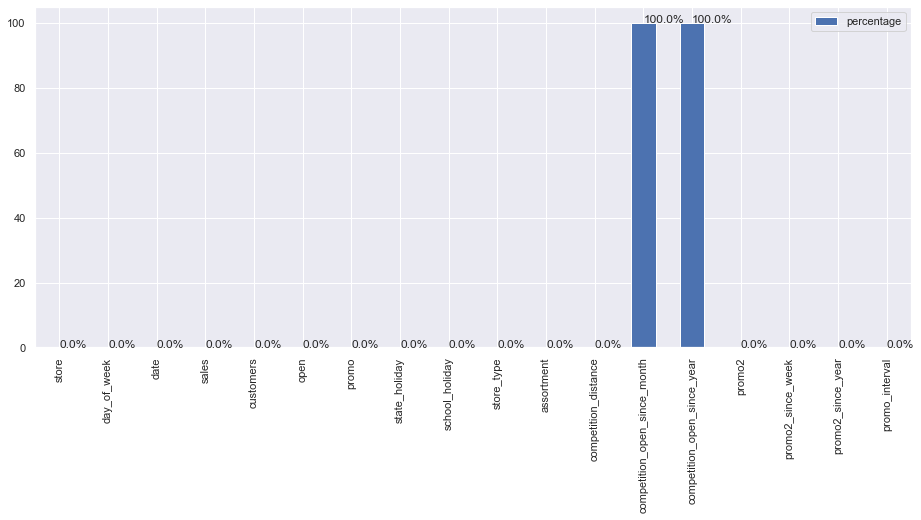

In [13]:
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

In [14]:
#Let's drop the promo2_since_year,promo2_since_year,promo_interval
df_new_store13=df_new_store13.drop(['competition_open_since_month', 'competition_open_since_year'], axis = 1)

In [15]:
df_new_store13.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [16]:
df_new_store13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 12 to 1016107
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   store                 758 non-null    int64         
 1   day_of_week           758 non-null    int64         
 2   date                  758 non-null    datetime64[ns]
 3   sales                 758 non-null    int64         
 4   customers             758 non-null    int64         
 5   open                  758 non-null    int64         
 6   promo                 758 non-null    int64         
 7   state_holiday         758 non-null    object        
 8   school_holiday        758 non-null    int64         
 9   store_type            758 non-null    object        
 10  assortment            758 non-null    object        
 11  competition_distance  758 non-null    float64       
 12  promo2                758 non-null    int64         
 13  promo2_since_we

In [17]:
# Let's copy the dataset
df_store13 = df_new_store13.copy()

In [18]:
df_store13.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2,promo2_since_week,promo2_since_year,promo_interval
12,13,5,2015-07-31,8821,568,1,1,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
1127,13,4,2015-07-30,7648,474,1,1,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
2242,13,3,2015-07-29,6648,406,1,1,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
3357,13,2,2015-07-28,6819,446,1,1,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
4472,13,1,2015-07-27,7926,527,1,1,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"


**Descriptive Statistics**

In [19]:
df_store13.describe().T

,count,mean,std,min,25%,50%,75%,max
store,758.0,13.000000,0.000000,13.0,13.00,13.0,13.00,13.0
day_of_week,758.0,4.001319,1.999009,1.0,2.00,4.0,6.00,7.0
sales,758.0,4124.773087,2429.243956,0.0,3135.25,4261.5,5784.25,10460.0
customers,758.0,313.641161,167.602980,0.0,276.00,345.5,421.00,672.0
open,758.0,0.819261,0.385056,0.0,1.00,1.0,1.00,1.0
promo,758.0,0.377309,0.485033,0.0,0.00,0.0,1.00,1.0
school_holiday,758.0,0.163588,0.370146,0.0,0.00,0.0,0.00,1.0
competition_distance,758.0,310.000000,0.000000,310.0,310.00,310.0,310.00,310.0
promo2,758.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
promo2_since_week,758.0,45.000000,0.000000,45.0,45.00,45.0,45.00,45.0


In [20]:
# separate numerical and categorical attributes
num_attributes = df_store13.select_dtypes( include = 'number')
cate_attributes = df_store13.select_dtypes( include = 'object')

**Numerical Attributes**

In [21]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,13.0,13.0,0.0,13.000000,13.0,0.000000,0.000000,0.000000
1,day_of_week,1.0,7.0,6.0,4.001319,4.0,1.997690,-0.001819,-1.246747
2,sales,0.0,10460.0,10460.0,4124.773087,4261.5,2427.641023,-0.258495,-0.417835
3,customers,0.0,672.0,672.0,313.641161,345.5,167.492387,-0.770709,-0.193274
4,open,0.0,1.0,1.0,0.819261,1.0,0.384802,-1.662647,0.766410
5,promo,0.0,1.0,1.0,0.377309,0.0,0.484713,0.507247,-1.747318
6,school_holiday,0.0,1.0,1.0,0.163588,0.0,0.369902,1.822533,1.325117
7,competition_distance,310.0,310.0,0.0,310.000000,310.0,0.000000,0.000000,0.000000
8,promo2,1.0,1.0,0.0,1.000000,1.0,0.000000,0.000000,0.000000
9,promo2_since_week,45.0,45.0,0.0,45.000000,45.0,0.000000,0.000000,0.000000


**Categorical Attributes**

In [22]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

state_holiday     5
store_type        1
assortment        1
promo_interval    1
dtype: int64

In [23]:
#Let's check the unique values
print(df_store13['state_holiday'].unique())
print(df_store13['store_type'].unique())
print(df_store13['assortment'].unique())
print(df_store13['promo_interval'].unique())

['0' 'a' 'b' 0 'c']
['d']
['a']
['Feb,May,Aug,Nov']


In [24]:
df_store13.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

# Exploratory data analysis(EDA)

Let’s perform EDA to gain insights into the given data.


**Univariate Analysis**

Response Variable (target)


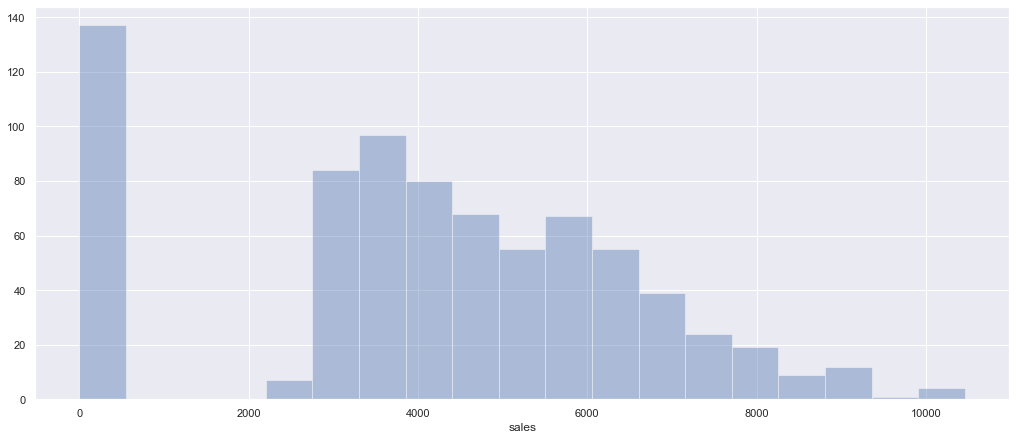

In [25]:
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df_store13['sales'], kde = False);
plt.show()

**Numerical Variable**


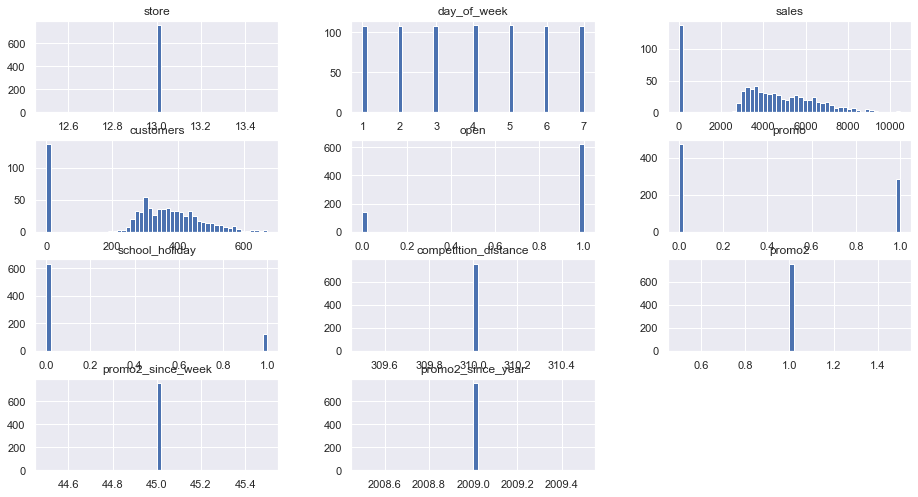

In [26]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
num_attributes.hist(bins = 50);

In [27]:
df_store13['day_of_week'].value_counts()
#day of the week

5    109
4    109
7    108
6    108
3    108
2    108
1    108
Name: day_of_week, dtype: int64

In [28]:
df_store13['open'].value_counts()
# value count of store is open or not

1    621
0    137
Name: open, dtype: int64

In [29]:
df_store13['school_holiday'].value_counts()
# value count of state_holiday

0    634
1    124
Name: school_holiday, dtype: int64

In [30]:
df_store13['store_type'].value_counts()
# value count of state_holiday

d    758
Name: store_type, dtype: int64

In [31]:
df_store13['assortment'].value_counts()
# value count of state_holiday

a    758
Name: assortment, dtype: int64

In [32]:
df_store13['competition_distance'].value_counts()
# value count of state_holiday

310.0    758
Name: competition_distance, dtype: int64

In [33]:
df_store13['promo2'].value_counts()
# value count of state_holiday

1    758
Name: promo2, dtype: int64

In [34]:
df_store13['promo2_since_week'].value_counts()
# value count of state_holiday

45.0    758
Name: promo2_since_week, dtype: int64

In [35]:
df_store13['promo2_since_year'].value_counts()
# value count of state_holiday

2009.0    758
Name: promo2_since_year, dtype: int64

In [36]:
df_store13['promo_interval'].value_counts()
# value count of state_holiday

Feb,May,Aug,Nov    758
Name: promo_interval, dtype: int64

**Categorical Variable**

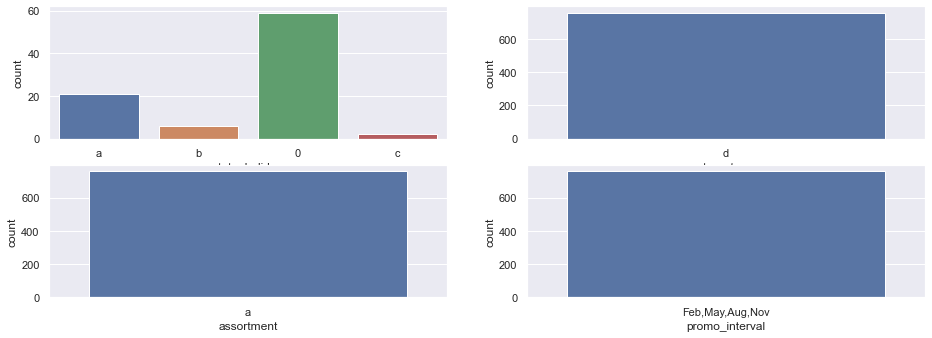

In [37]:
# state_holiday
plt.subplot(3, 2, 1)
a = df_store13[df_store13['state_holiday'] != '0']
sns.countplot(data = a, x = a['state_holiday'])

# store_type
plt.subplot(3, 2, 2)
sns.countplot(data = df_store13, x = df_store13['store_type'])

# assortment
plt.subplot(3, 2, 3)
sns.countplot(data = df_store13, x = df_store13['assortment'])

# promo_interval
plt.subplot(3, 2, 4)
sns.countplot(data = df_store13, x = df_store13['promo_interval'])


plt.show()

In [38]:
# Zero values in sales 
df_store13[df_store13['sales']==0]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2,promo2_since_week,promo2_since_year,promo_interval
5587,13,7,2015-07-26,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
13392,13,7,2015-07-19,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
21197,13,7,2015-07-12,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
29002,13,7,2015-07-05,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
36807,13,7,2015-06-28,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987117,13,7,2013-01-27,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
994922,13,7,2013-01-20,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
1002727,13,7,2013-01-13,0,0,0,0,0,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
1010532,13,7,2013-01-06,0,0,0,0,a,0,d,a,310.0,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [39]:
df_store13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 12 to 1016107
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   store                 758 non-null    int64         
 1   day_of_week           758 non-null    int64         
 2   date                  758 non-null    datetime64[ns]
 3   sales                 758 non-null    int64         
 4   customers             758 non-null    int64         
 5   open                  758 non-null    int64         
 6   promo                 758 non-null    int64         
 7   state_holiday         758 non-null    object        
 8   school_holiday        758 non-null    int64         
 9   store_type            758 non-null    object        
 10  assortment            758 non-null    object        
 11  competition_distance  758 non-null    float64       
 12  promo2                758 non-null    int64         
 13  promo2_since_we


-    Sale  and customer colomns has zero values which has to be imputed

-    Store is open on 80% of days

-    80% are regular days

-    All the rows of column-store type belongs to 'd'

-    All the rows of column-assortment belongs to 'a'

-    All the rows of columns-competition_distance to 310

-    All the competition is opened since month-45

-    All the competition is opened since 2009

-    All the rows of promo2 belogs to 1



**Bivariate Analysis**

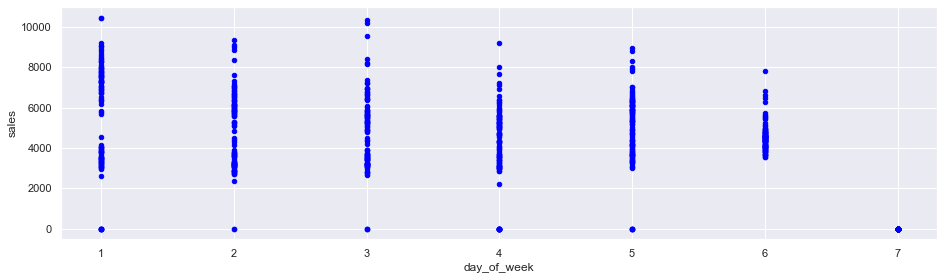

In [40]:
# lets draw a scatter plot between  Sales and day_of_week
sns.set(rc={'figure.figsize':(15.7,4.27)})
df_store13[['sales', 'day_of_week']].plot.scatter(x = 'day_of_week',y='sales',c='blue')
plt.show()

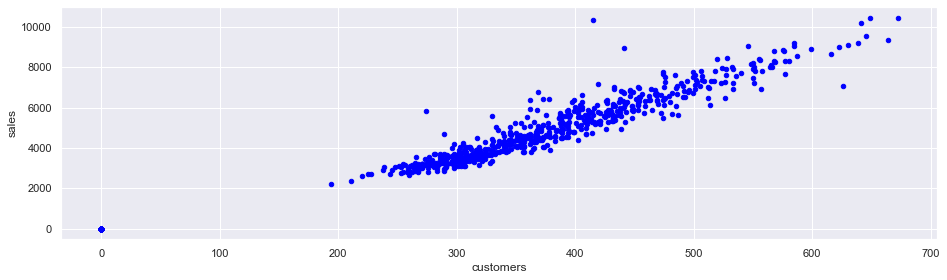

In [41]:
#Let's draw a scatter plot between Sales and Customers
df_store13[['sales', 'customers']].plot.scatter(x = 'customers',y='sales',c='blue')
plt.show()

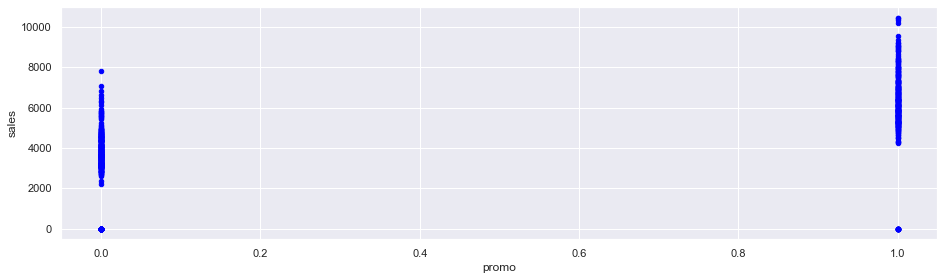

In [42]:
#Let's now draw a scatter plot between Sales and promo
df_store13[['sales', 'promo']].plot.scatter(x = 'promo',y='sales',c='blue')
plt.show()

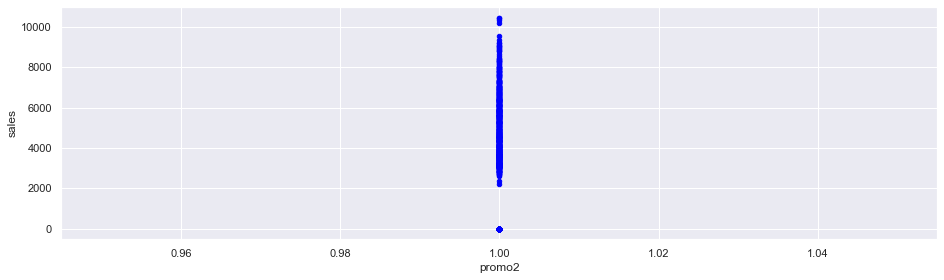

In [43]:
#Let's now draw a scatter plot between Sales and promo
df_store13[['sales', 'promo2']].plot.scatter(x = 'promo2',y='sales',c='blue')
plt.show()

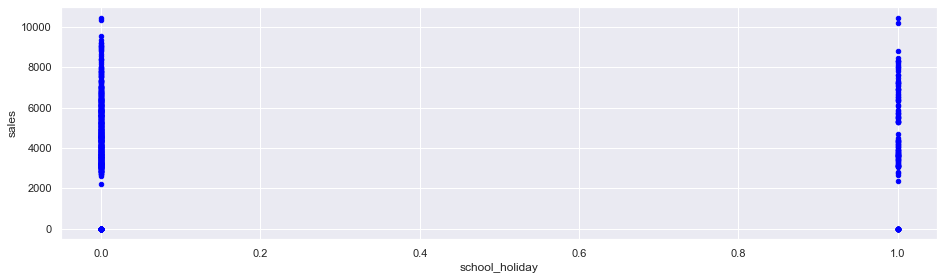

In [44]:
#lets now draw a scatter plot between  Sales and school_holiday
df_store13[['sales', 'school_holiday']].plot.scatter(x = 'school_holiday',y='sales',c='blue')
plt.show()

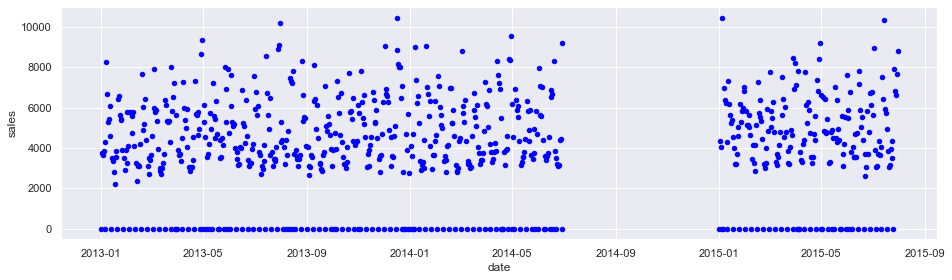

In [45]:
#lets now draw a scatter plot between Sales and date
df_store13[['sales', 'date']].plot.scatter(x = 'date',y='sales',c='blue')
plt.show()

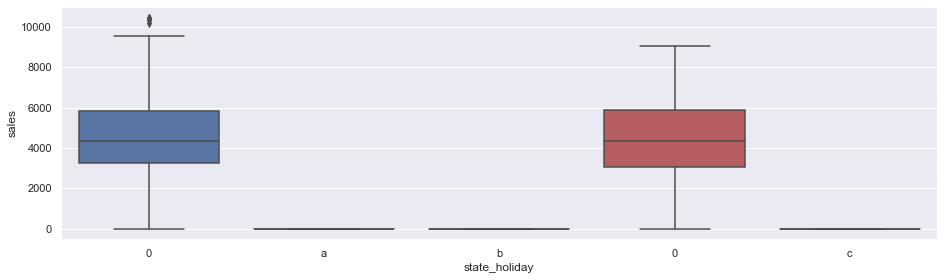

In [46]:
#Let's draw the boxplot between sales and state_holiday
sns.set(rc={'figure.figsize':(15.7,4.27)})
# create grouped boxplot 
sns.boxplot(x = df_store13['state_holiday'],
            y = df_store13['sales'])
plt.show()

**Multivariate Analysis**

**Numerical Attributes**

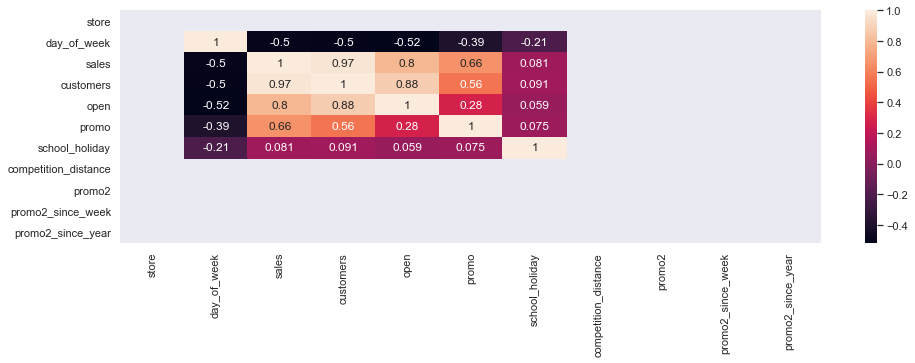

In [47]:
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

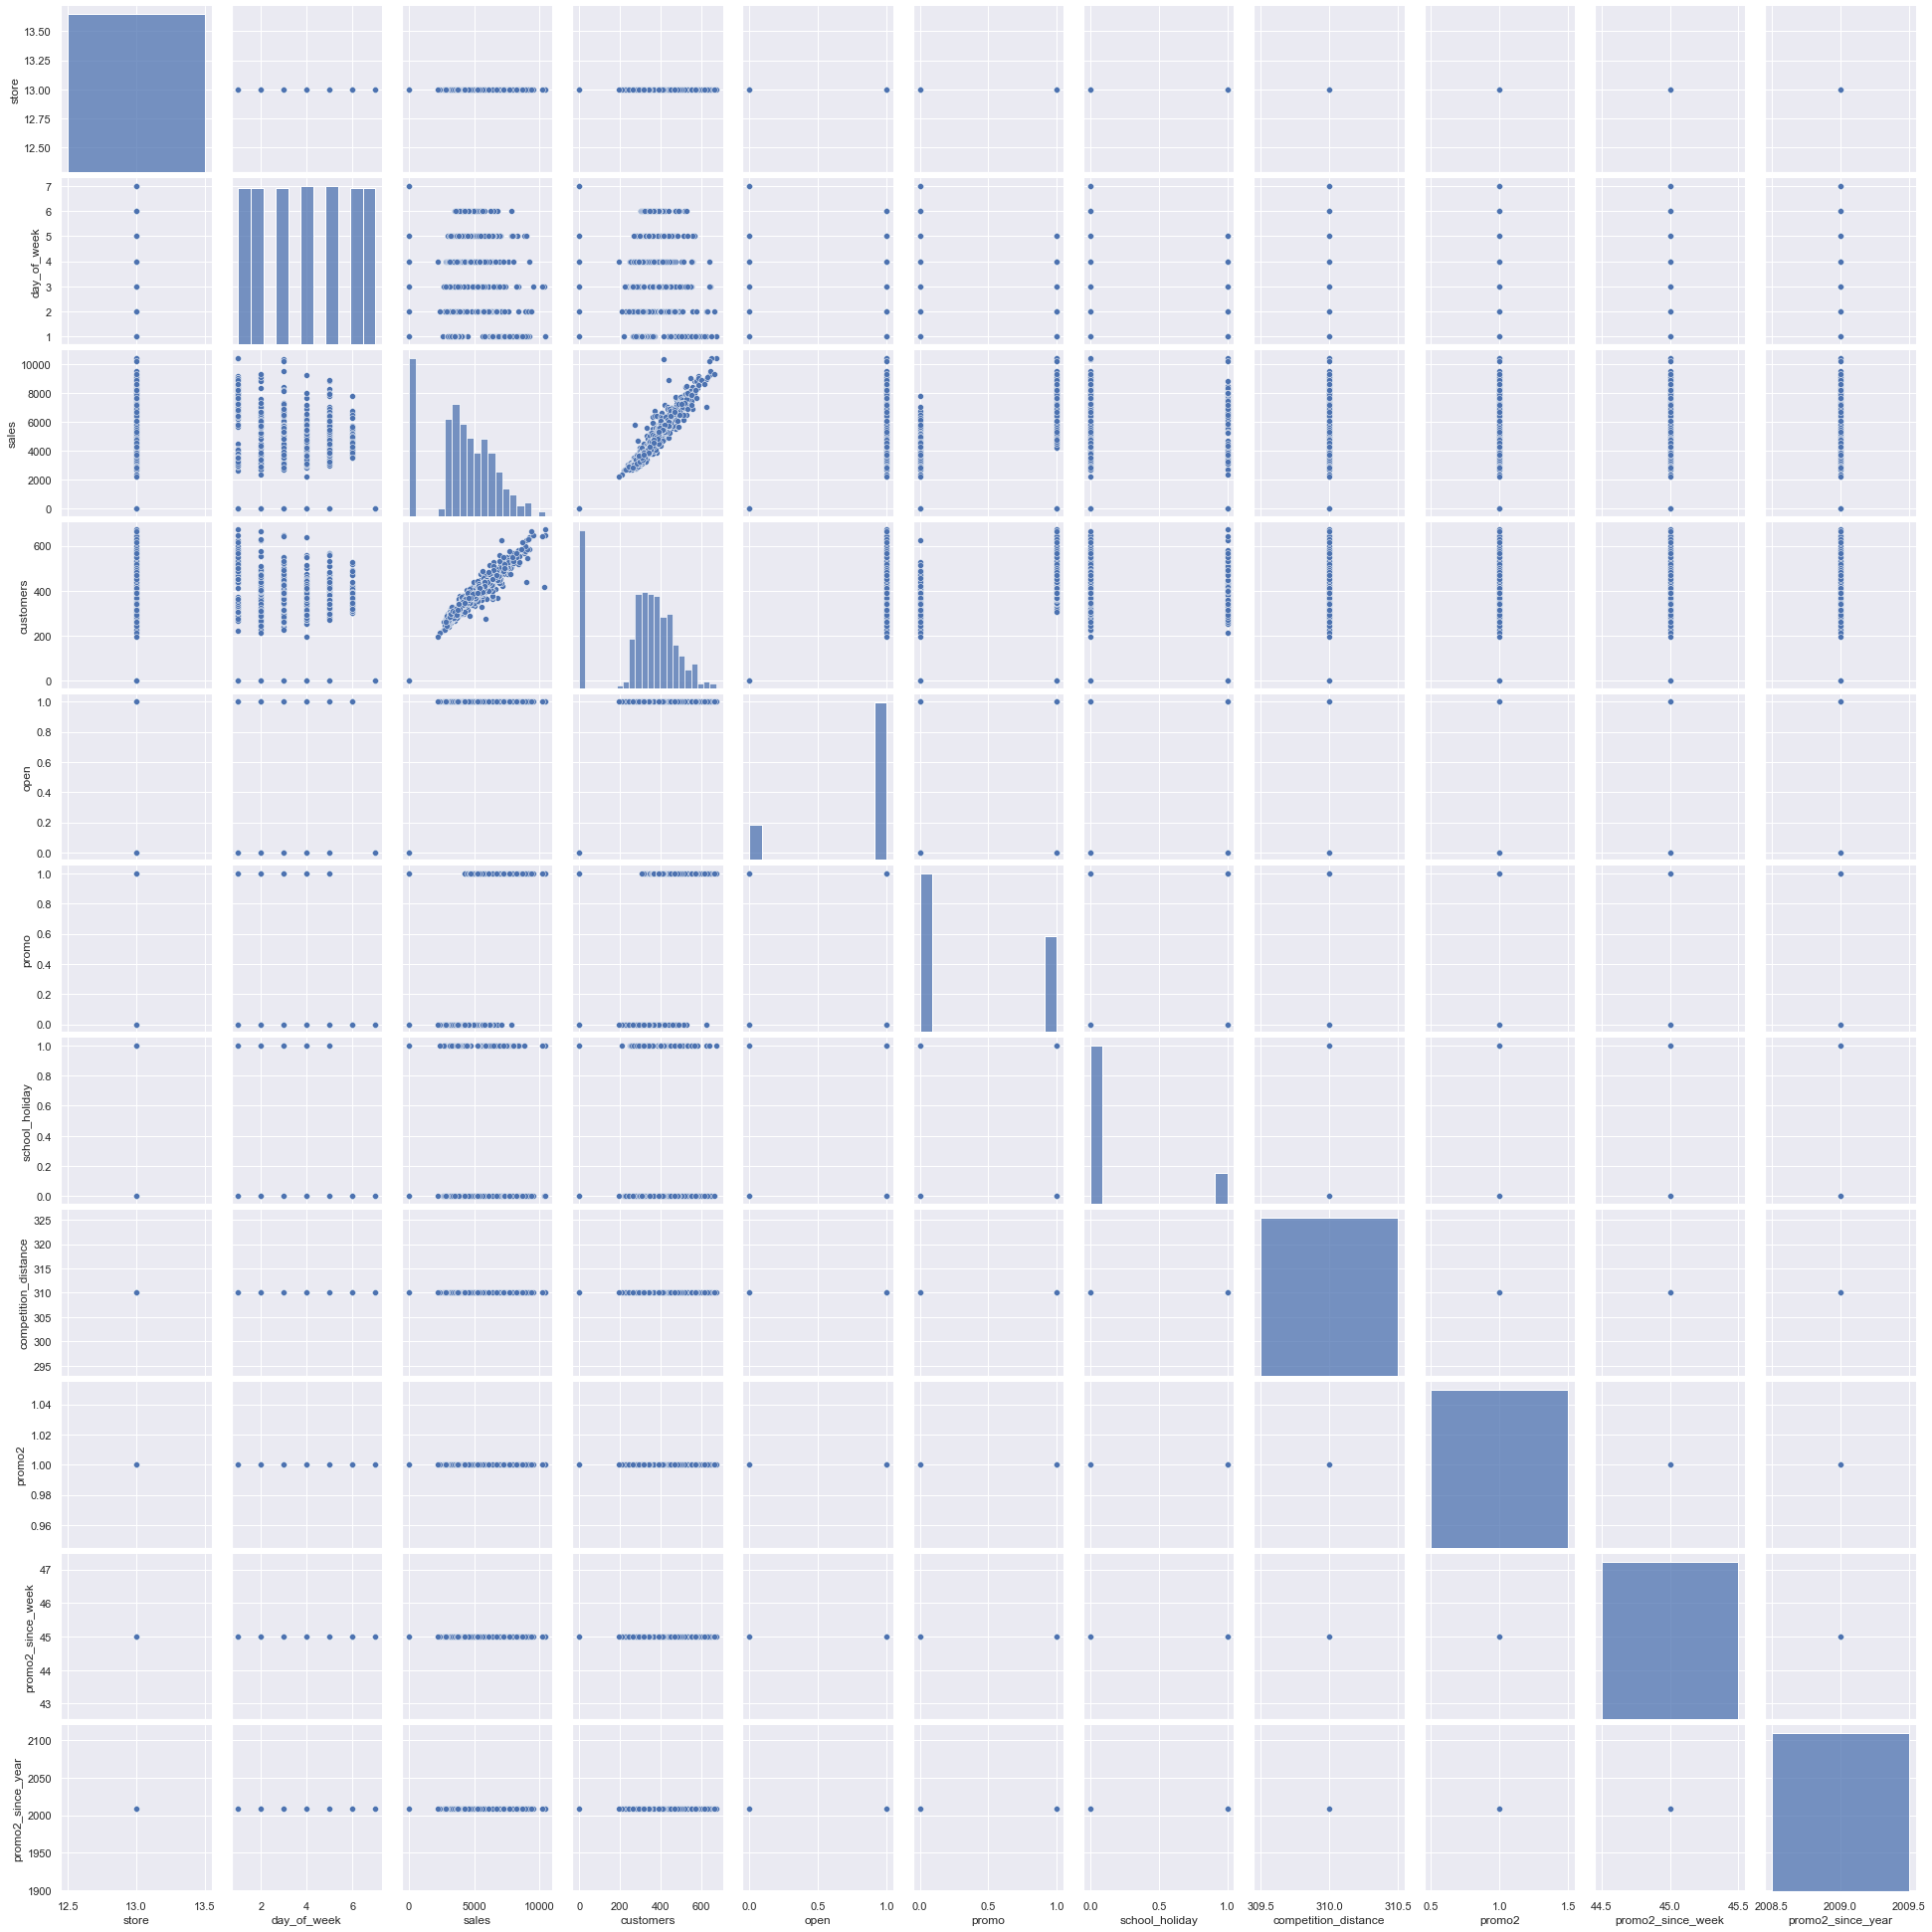

In [48]:
#pairplot with hue sales
sns.pairplot(df_store13)
# to show
plt.show()

**Some insights from EDA**

   - store_type,assortment,competition_distance,promo2_since_week,promo2_since_year,promo_interval

   - Day1 and Day3 have higher sales than other days

   - promo is correlated to sales

   - Promo2 doesn't have any effect on sales becuase it's value is equal to 1

   - There is no sale on a = public holiday, b = Easter holiday, c = Christmas

   - There is some effect of school holiday on sales

In [49]:
#We can drop store_type,assortment,competition_distance,competition_open_since_month,promo2_since_week,promo2_since_year,promo_interval
#competition_open_since_year & promo2
df_store13_new=df_store13.drop(['store_type', 'assortment','competition_distance','promo2_since_week','promo2_since_year','promo_interval'], axis = 1)
df_store13_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758 entries, 12 to 1016107
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   store           758 non-null    int64         
 1   day_of_week     758 non-null    int64         
 2   date            758 non-null    datetime64[ns]
 3   sales           758 non-null    int64         
 4   customers       758 non-null    int64         
 5   open            758 non-null    int64         
 6   promo           758 non-null    int64         
 7   state_holiday   758 non-null    object        
 8   school_holiday  758 non-null    int64         
 9   promo2          758 non-null    int64         
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 85.1+ KB


In [50]:
df_store13_new.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2'],
      dtype='object')

In [51]:
df_store13_new.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
12,13,5,2015-07-31,8821,568,1,1,0,0,1
1127,13,4,2015-07-30,7648,474,1,1,0,0,1
2242,13,3,2015-07-29,6648,406,1,1,0,0,1
3357,13,2,2015-07-28,6819,446,1,1,0,0,1
4472,13,1,2015-07-27,7926,527,1,1,0,0,1


In [52]:
# saving the dataframe
#df_store13_new.to_csv('cleaned_df_store13.csv')

# Model Building

**ARIMA model**

In [53]:
path = "cleaned_df_store13.csv"
df_store13_new = pd.read_csv(path)
df_store13_new.head()
#Let load the data

,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,12,13,5,2015-07-31,8821,568,1,1,0,0,1
1,1127,13,4,2015-07-30,7648,474,1,1,0,0,1
2,2242,13,3,2015-07-29,6648,406,1,1,0,0,1
3,3357,13,2,2015-07-28,6819,446,1,1,0,0,1
4,4472,13,1,2015-07-27,7926,527,1,1,0,0,1


In [54]:
df_store13_new=df_store13_new[::-1].reset_index()
df_store13_new.head()

,index,Unnamed: 0,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,757,1016107,13,2,2013-01-01,0,0,0,0,a,1,1
1,756,1014992,13,3,2013-01-02,3737,317,1,0,0,1,1
2,755,1013877,13,4,2013-01-03,3674,292,1,0,0,1,1
3,754,1012762,13,5,2013-01-04,3848,340,1,0,0,1,1
4,753,1011647,13,6,2013-01-05,4285,344,1,0,0,0,1


In [55]:
df_store13_new=df_store13_new.drop(['Unnamed: 0'], axis = 1)
df_store13_new=df_store13_new.drop(['index'], axis = 1)
df_store13_new.head()
#Let drop the Unnamed: 0 column

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,promo2
0,13,2,2013-01-01,0,0,0,0,a,1,1
1,13,3,2013-01-02,3737,317,1,0,0,1,1
2,13,4,2013-01-03,3674,292,1,0,0,1,1
3,13,5,2013-01-04,3848,340,1,0,0,1,1
4,13,6,2013-01-05,4285,344,1,0,0,0,1


In [56]:
df_store13_new.info()
#No missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   store           758 non-null    int64 
 1   day_of_week     758 non-null    int64 
 2   date            758 non-null    object
 3   sales           758 non-null    int64 
 4   customers       758 non-null    int64 
 5   open            758 non-null    int64 
 6   promo           758 non-null    int64 
 7   state_holiday   758 non-null    object
 8   school_holiday  758 non-null    int64 
 9   promo2          758 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 59.3+ KB


In [57]:
# transform datatype of the variable data to datetime
df_store13_new['date'] = pd.to_datetime(df_store13_new['date'])

In [58]:
indexed_df_store13_new = df_store13_new.set_index(['date'])
indexed_df_store13_new.head()
#Let set the date as index column

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,13,2,0,0,0,0,a,1,1
2013-01-02,13,3,3737,317,1,0,0,1,1
2013-01-03,13,4,3674,292,1,0,0,1,1
2013-01-04,13,5,3848,340,1,0,0,1,1
2013-01-05,13,6,4285,344,1,0,0,0,1


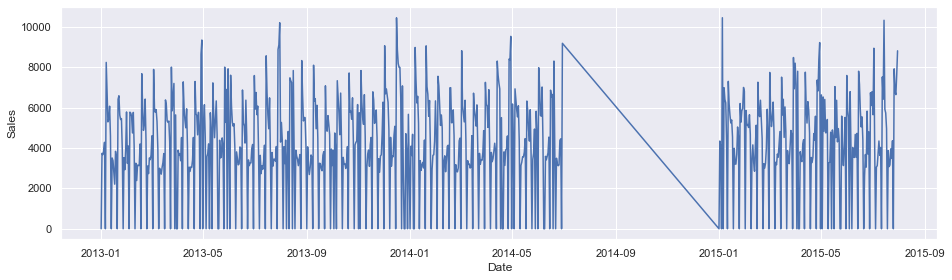

In [59]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store13_new['sales'])
plt.show()

In [61]:
#Let impute the zero values
(indexed_df_store13_new['sales']==0).sum()
# There are 137 zero value in sale column

137

In [62]:
indexed_df_store13_new['sales']=indexed_df_store13_new['sales'].replace(0, np.nan)

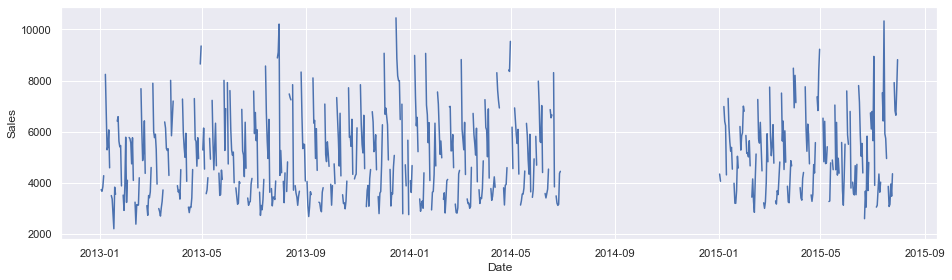

In [63]:
##plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store13_new['sales'])
plt.show()

In [64]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [65]:
indexed_df_store13_new['sales'] = imputer.fit_transform(np.array(indexed_df_store13_new['sales']).reshape(-1, 1))
indexed_df_store13_new['sales'].head()

date
2013-01-01    5034.747182
2013-01-02    3737.000000
2013-01-03    3674.000000
2013-01-04    3848.000000
2013-01-05    4285.000000
Name: sales, dtype: float64

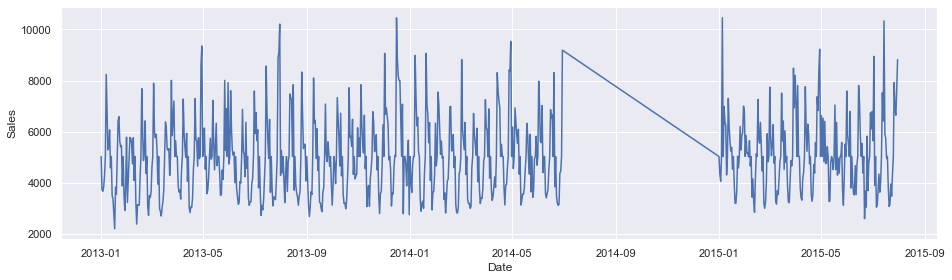

In [66]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store13_new['sales'])
plt.show()

In [67]:
(indexed_df_store13_new['sales']==0).sum()
# no missing value

0

**We have filled the zero values but data from 01/07/2014 to 31/12/2014 is missing. It will create a problem to create a model so we should keep the data till 30/06/2014 for modelling**

In [79]:
indexed_df_store13_new1=indexed_df_store13_new[:546]
indexed_df_store13_new1.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2
date,,,,,,,,,
2013-01-01,13,2,5034.747182,0,0,0,a,1,1
2013-01-02,13,3,3737.000000,317,1,0,0,1,1
2013-01-03,13,4,3674.000000,292,1,0,0,1,1
2013-01-04,13,5,3848.000000,340,1,0,0,1,1
2013-01-05,13,6,4285.000000,344,1,0,0,0,1


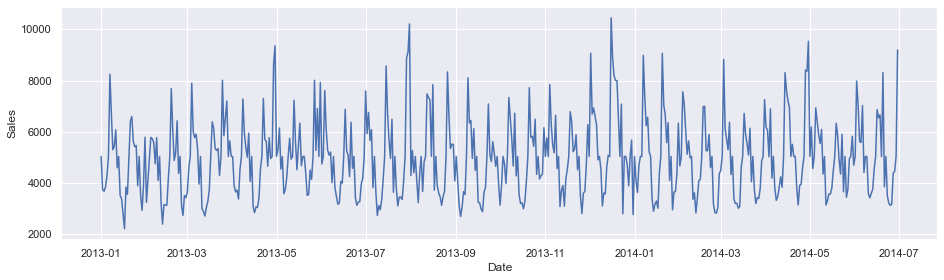

In [80]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sales')
plt.plot(indexed_df_store13_new1['sales'])
plt.show()

**Outlier detection**

Box plot and interquartile range

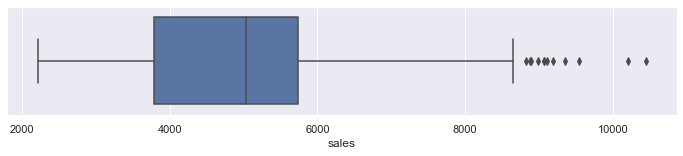

In [87]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store13_new1['sales'],whis=1.5)
#Let treat the outliers

**Histogram**

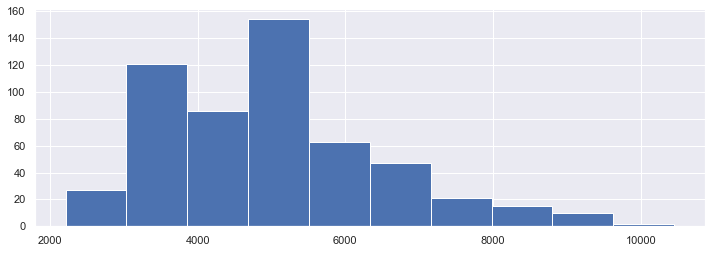

In [88]:
fig = indexed_df_store13_new1['sales'].hist(figsize = (12,4))

In [90]:
percentile01 = indexed_df_store13_new1['sales'].quantile(0.01)
percentile99 = indexed_df_store13_new1['sales'].quantile(0.99)

In [91]:
upper_limit = percentile99
lower_limit = percentile01

In [92]:
upper_limit

9092.449999999997

In [93]:
lower_limit

2746.6000000000004

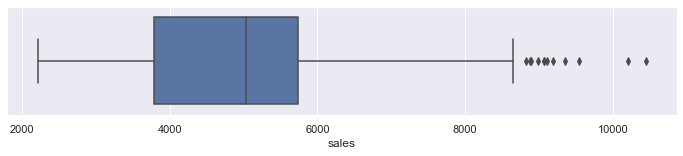

In [94]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store13_new1['sales'],whis=1.5)

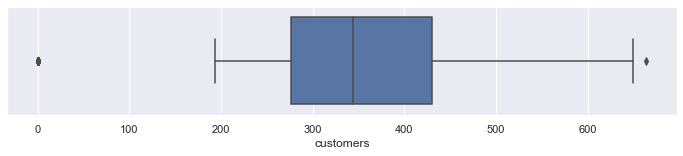

In [95]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=indexed_df_store13_new1['customers'],whis=1.5)

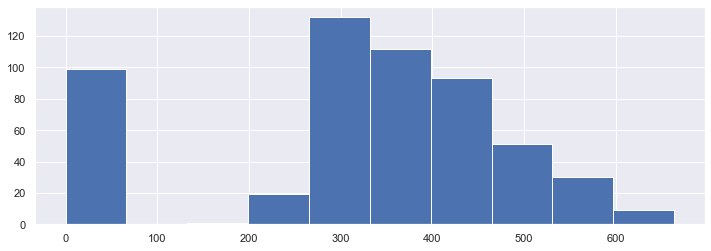

In [96]:
fig = indexed_df_store13_new1['customers'].hist(figsize = (12,4))

**ADF Stationary**

In [97]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(indexed_df_store13_new1['sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

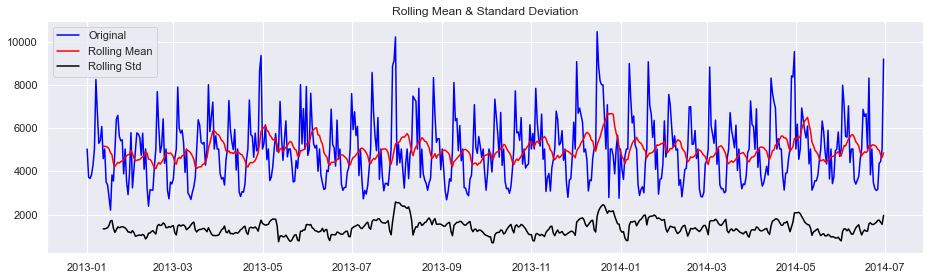

Results of Dickey Fuller Test:
Test Statistic                -5.693638e+00
p-value                        7.965604e-07
#Lags Used                     1.500000e+01
Number of Observations Used    5.300000e+02
Critical Value (1%)           -3.442749e+00
Critical Value (5%)           -2.867009e+00
Critical Value (10%)          -2.569683e+00
dtype: float64


In [98]:
test_stationarity(indexed_df_store13_new1['sales'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [100]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(indexed_df_store13_new1['sales'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.191785
Critical Values @ 0.05: 0.46
p-value: 0.100000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary
    
**The p-value is greater than 0.05 so The series is stationary**

# Let's take the log of sales to Standardize the sales values

In [104]:
new_df=indexed_df_store13_new1.copy()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 546 entries, 2013-01-01 to 2014-06-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store           546 non-null    int64  
 1   day_of_week     546 non-null    int64  
 2   sales           546 non-null    float64
 3   customers       546 non-null    int64  
 4   open            546 non-null    int64  
 5   promo           546 non-null    int64  
 6   state_holiday   546 non-null    object 
 7   school_holiday  546 non-null    int64  
 8   promo2          546 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 42.7+ KB


In [105]:
#Log Transformation
new_df['sales_log'] = np.log(new_df['sales'])
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log
date,,,,,,,,,,
2013-01-01,13,2,5034.747182,0,0,0,a,1,1,8.524119
2013-01-02,13,3,3737.000000,317,1,0,0,1,1,8.226038
2013-01-03,13,4,3674.000000,292,1,0,0,1,1,8.209036
2013-01-04,13,5,3848.000000,340,1,0,0,1,1,8.255309
2013-01-05,13,6,4285.000000,344,1,0,0,0,1,8.362876


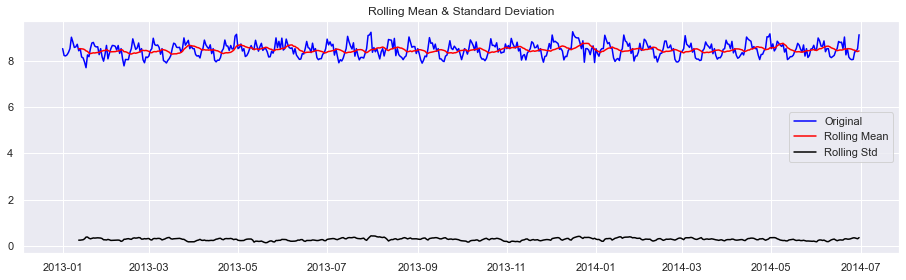

Results of Dickey Fuller Test:
Test Statistic                -5.693638e+00
p-value                        7.965604e-07
#Lags Used                     1.500000e+01
Number of Observations Used    5.300000e+02
Critical Value (1%)           -3.442749e+00
Critical Value (5%)           -2.867009e+00
Critical Value (10%)          -2.569683e+00
dtype: float64


In [106]:
test_stationarity(new_df['sales_log'])

**Log transformation has made mean & variance constant**


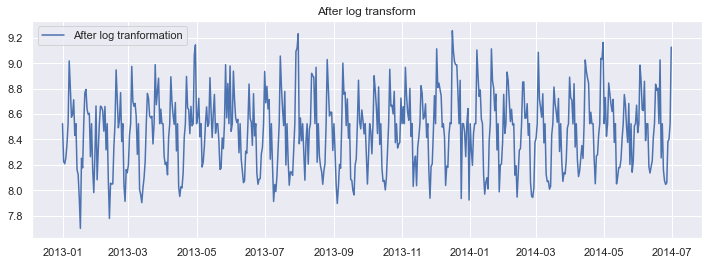

In [107]:
#After Log Transformation
plt.figure(figsize=(12,4))
plt.plot(new_df['sales_log'], label='After log tranformation')
plt.legend(loc='best')
plt.title('After log transform')
plt.show()

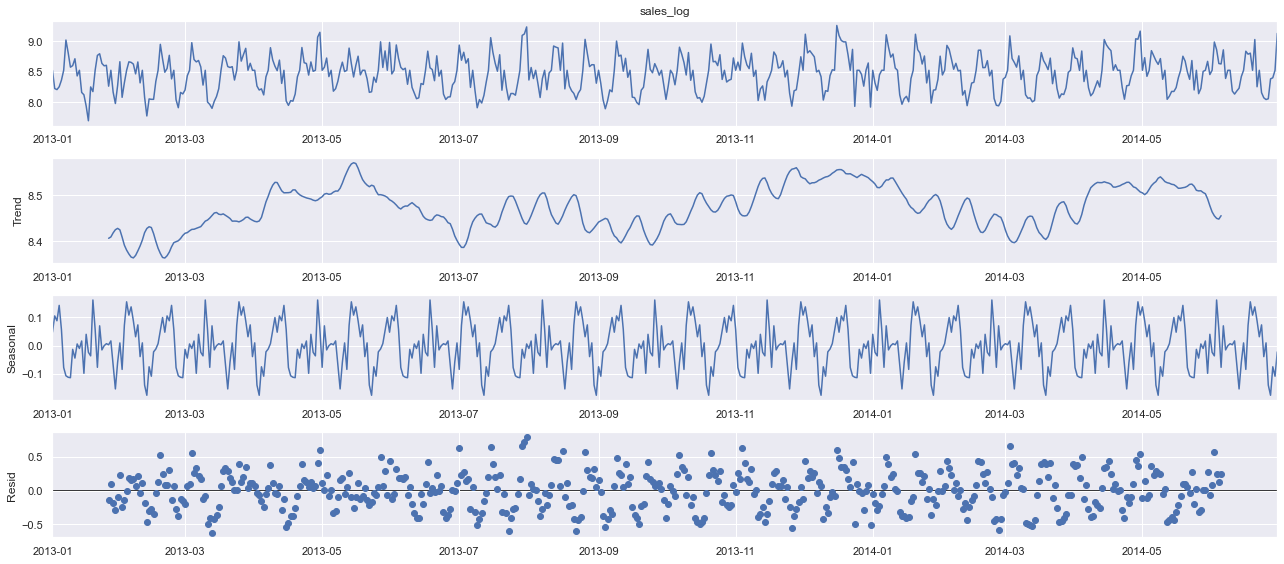

In [108]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "additive",period=50)
fig = decomposition.plot()

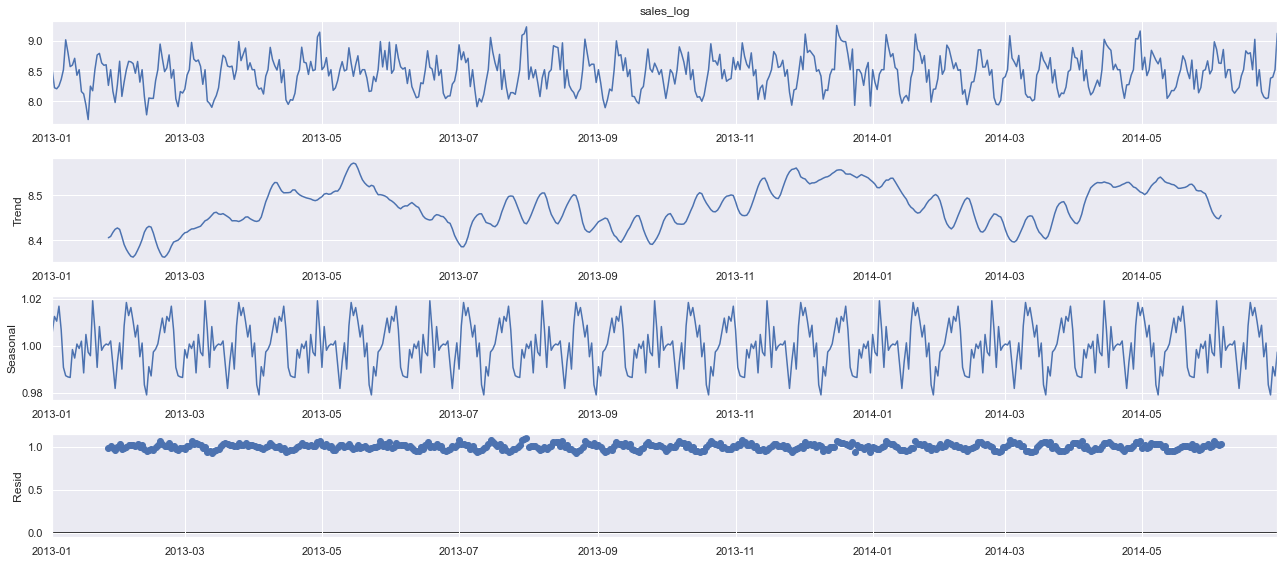

In [109]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(new_df['sales_log'], model = "multiplicative",period=50)
fig = decomposition.plot()

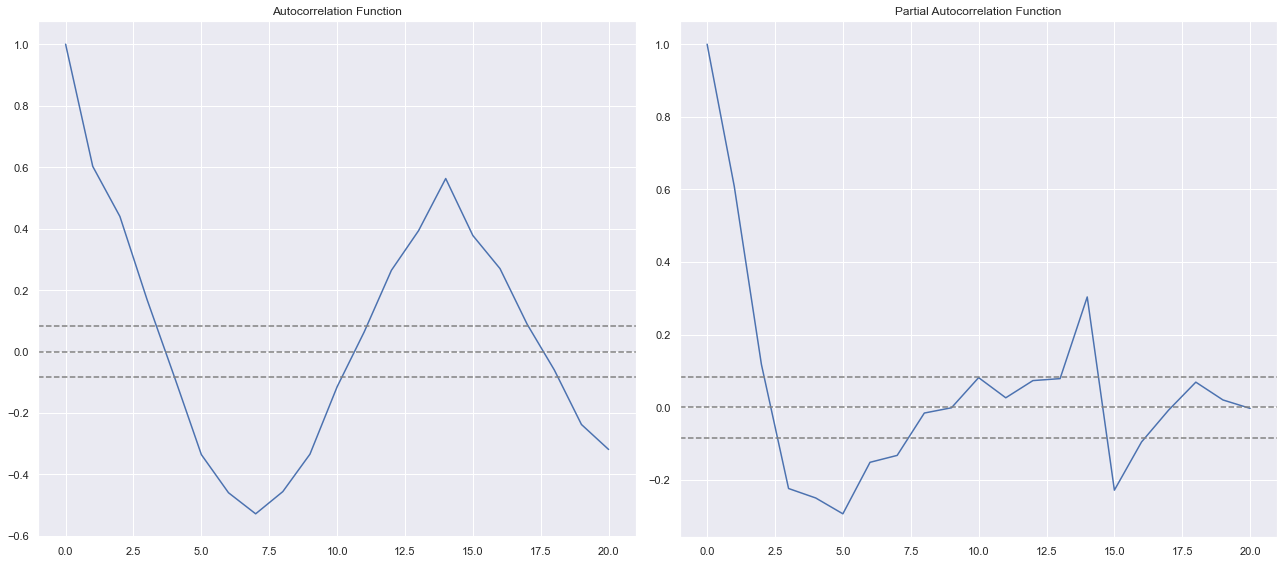

In [110]:
#ACF & PACF plots

lag_acf = acf(new_df['sales_log'], nlags=20) # MA 
lag_pacf = pacf(new_df['sales_log'], nlags=20, method='ols')  # AR 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_df['sales_log'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

From the ACF graph, we see that curve touches y=0.0 line at x=4. Thus, from theory, Q = 4 From the PACF graph, we see that curve touches y=0.0 line at x=3. Thus, from theory, P = 3

**Build and evaluate time series forecast**

Split time series data into training and test set


In [113]:
train_len = 446
train = new_df['sales'][0:train_len] # first 750days as training set
test = new_df['sales'][train_len:] # last 182 days as out-of-time test set

In [114]:
print(train.shape)
print(test.shape)

(446,)
(100,)


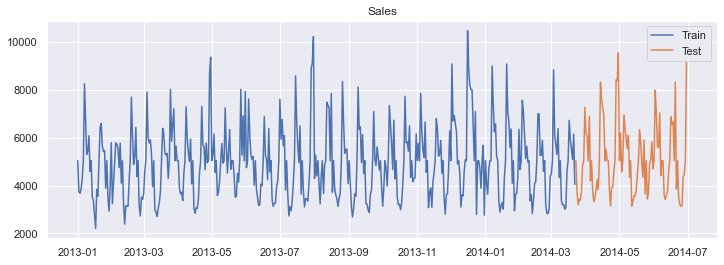

In [115]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

In [116]:
model = ARIMA(new_df['sales_log'], order=(3, 0, 4))
model_fit = model.fit()
print(model_fit.params)

const              8.472804
ar.L1.sales_log    0.770553
ar.L2.sales_log    0.778541
ar.L3.sales_log   -0.938403
ma.L1.sales_log   -0.403642
ma.L2.sales_log   -0.744620
ma.L3.sales_log    0.593965
ma.L4.sales_log    0.066306
dtype: float64


In [117]:
new_df['ar_forecast_Log'] = model_fit.predict(new_df.index.min(), new_df.index.max())
new_df['arima_forecast'] = np.exp(new_df['ar_forecast_Log'])
new_df['arima_forecast']

date
2013-01-01    4782.907347
2013-01-02    4935.242128
2013-01-03    4208.145517
2013-01-04    3832.251371
2013-01-05    4022.594208
                 ...     
2014-06-26    3664.888334
2014-06-27    3551.756128
2014-06-28    4789.504154
2014-06-29    5016.745334
2014-06-30    6046.202238
Name: arima_forecast, Length: 546, dtype: float64

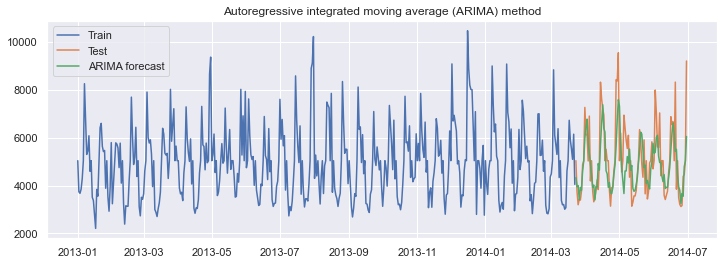

In [118]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(new_df['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

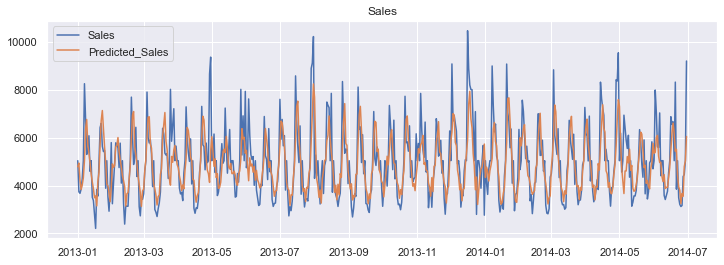

In [119]:
# plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['sales'], label='Sales')
plt.plot(new_df['arima_forecast'], label='Predicted_Sales')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

**Model Evalution**

In [120]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, new_df['arima_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test-new_df['arima_forecast'][test.index.min():])/test)*100,2)
Results = pd.DataFrame({'Method':['ARIMA'], 'RMSE': [rmse],'MAPE': [mape] })
Results

,Method,RMSE,MAPE
0,ARIMA,1081.61,14.95


**VAR model**

In [122]:
#Load the dataset
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,13,2,5034.747182,0,0,0,a,1,1,8.524119,8.472804,4782.907347
2013-01-02,13,3,3737.000000,317,1,0,0,1,1,8.226038,8.504157,4935.242128
2013-01-03,13,4,3674.000000,292,1,0,0,1,1,8.209036,8.344777,4208.145517
2013-01-04,13,5,3848.000000,340,1,0,0,1,1,8.255309,8.251208,3832.251371
2013-01-05,13,6,4285.000000,344,1,0,0,0,1,8.362876,8.299682,4022.594208


**Split the dataset to training & testing**

In [123]:
#split the dataset
nobs = 100
train, test = new_df[0:-nobs], new_df[-nobs:]

# Check size
print(train.shape)
print(test.shape)  

(446, 12)
(100, 12)


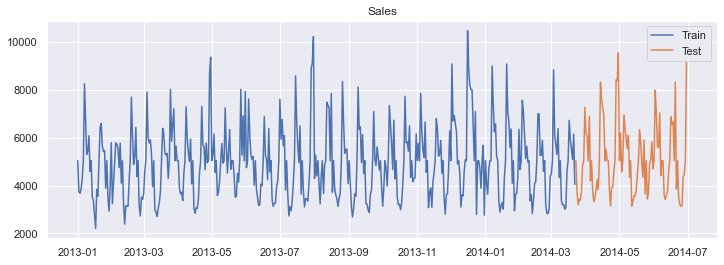

In [124]:
plt.figure(figsize=(12,4))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.legend(loc='best')
plt.title('Sales')
plt.show()

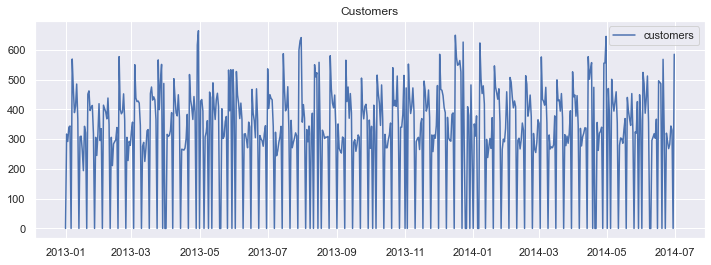

In [125]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [126]:
(new_df['customers']==0).sum()

99

In [127]:
#impute the NAN values
new_df['customers']=new_df['customers'].replace(0, np.nan)

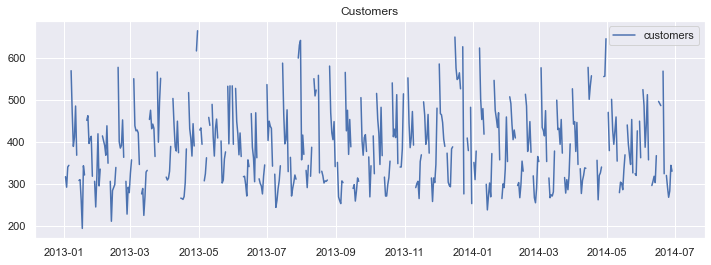

In [128]:
#plot the arima forecasting & Original series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers'],label='customers')
plt.legend(loc='best')
plt.title('Customers')
plt.show()

In [129]:
#KNN imputer for filling NAN values
imputer = KNNImputer(n_neighbors=2)

In [130]:
new_df['customers'] = imputer.fit_transform(np.array(new_df['customers']).reshape(-1, 1))
new_df['customers'].head()

date
2013-01-01    387.149888
2013-01-02    317.000000
2013-01-03    292.000000
2013-01-04    340.000000
2013-01-05    344.000000
Name: customers, dtype: float64

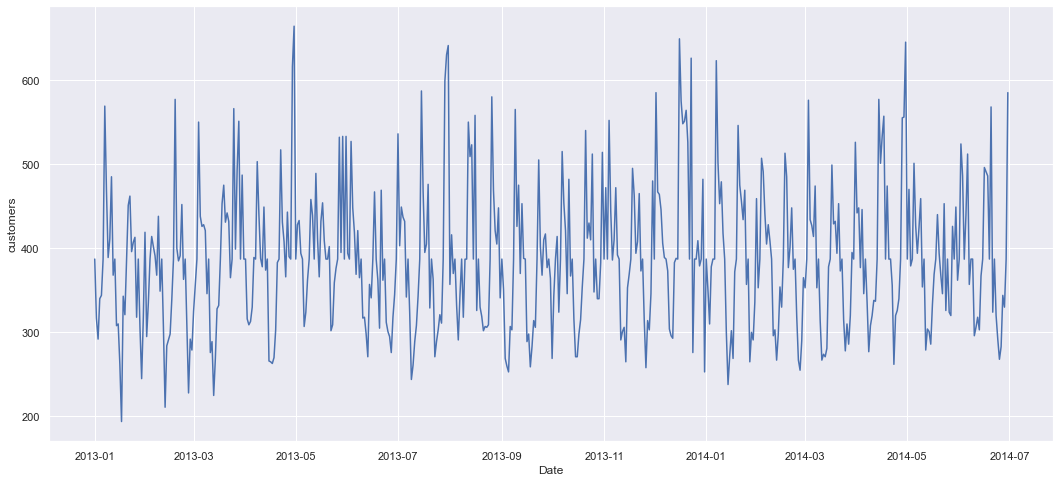

In [131]:
## plot graph
plt.xlabel('Date')
plt.ylabel('customers')
plt.plot(new_df['customers'])
plt.show()

In [132]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast
date,,,,,,,,,,,,
2013-01-01,13,2,5034.747182,387.149888,0,0,a,1,1,8.524119,8.472804,4782.907347
2013-01-02,13,3,3737.000000,317.000000,1,0,0,1,1,8.226038,8.504157,4935.242128
2013-01-03,13,4,3674.000000,292.000000,1,0,0,1,1,8.209036,8.344777,4208.145517
2013-01-04,13,5,3848.000000,340.000000,1,0,0,1,1,8.255309,8.251208,3832.251371
2013-01-05,13,6,4285.000000,344.000000,1,0,0,0,1,8.362876,8.299682,4022.594208


**ADF test**

In [133]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(new_df['customers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

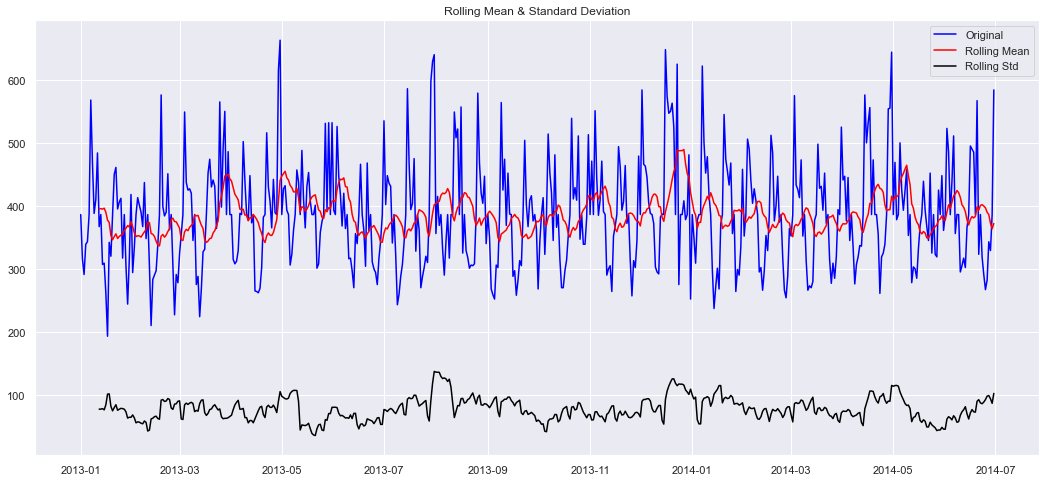

Results of Dickey Fuller Test:
Test Statistic                  -4.800083
p-value                          0.000054
#Lags Used                      17.000000
Number of Observations Used    528.000000
Critical Value (1%)             -3.442796
Critical Value (5%)             -2.867030
Critical Value (10%)            -2.569694
dtype: float64


In [134]:
test_stationarity(new_df['customers'])

- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is stationary**

In [136]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(new_df['customers'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.142600
Critical Values @ 0.05: 0.46
p-value: 0.100000


- Null: Time Series is not stationary
- Alternate: Time Series is Stationary

**The p-value is less than 0.05 so The series is non-stationary**

In [140]:
#Log Transformation
new_df['customers_log'] = np.log(new_df['customers'])
new_df.head()

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,13,2,5034.747182,387.149888,0,0,a,1,1,8.524119,8.472804,4782.907347,5.958812
2013-01-02,13,3,3737.000000,317.000000,1,0,0,1,1,8.226038,8.504157,4935.242128,5.758902
2013-01-03,13,4,3674.000000,292.000000,1,0,0,1,1,8.209036,8.344777,4208.145517,5.676754
2013-01-04,13,5,3848.000000,340.000000,1,0,0,1,1,8.255309,8.251208,3832.251371,5.828946
2013-01-05,13,6,4285.000000,344.000000,1,0,0,0,1,8.362876,8.299682,4022.594208,5.840642


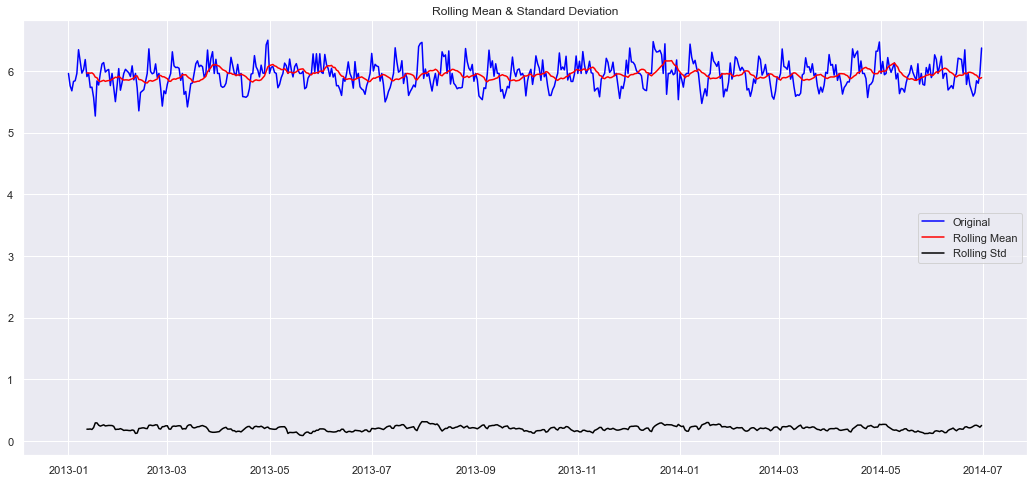

Results of Dickey Fuller Test:
Test Statistic                  -4.800083
p-value                          0.000054
#Lags Used                      17.000000
Number of Observations Used    528.000000
Critical Value (1%)             -3.442796
Critical Value (5%)             -2.867030
Critical Value (10%)            -2.569694
dtype: float64


In [141]:
test_stationarity(new_df['customers_log'])

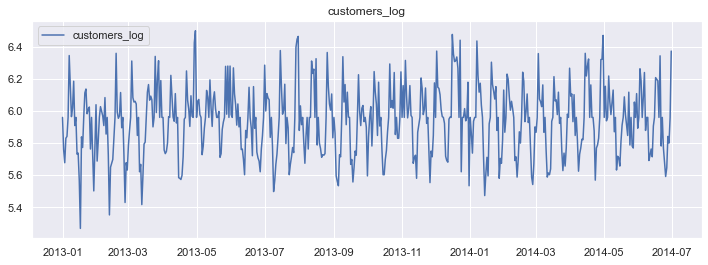

In [142]:
#plot the arima Log series
plt.figure(figsize=(12,4))
plt.plot(new_df['customers_log'],label='customers_log')
plt.legend(loc='best')
plt.title('customers_log')
plt.show()

In [143]:
#Let's check the info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 546 entries, 2013-01-01 to 2014-06-30
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store            546 non-null    int64  
 1   day_of_week      546 non-null    int64  
 2   sales            546 non-null    float64
 3   customers        546 non-null    float64
 4   open             546 non-null    int64  
 5   promo            546 non-null    int64  
 6   state_holiday    546 non-null    object 
 7   school_holiday   546 non-null    int64  
 8   promo2           546 non-null    int64  
 9   sales_log        546 non-null    float64
 10  ar_forecast_Log  546 non-null    float64
 11  arima_forecast   546 non-null    float64
 12  customers_log    546 non-null    float64
dtypes: float64(6), int64(6), object(1)
memory usage: 79.7+ KB


**Log transformation has made mean & variance constant**

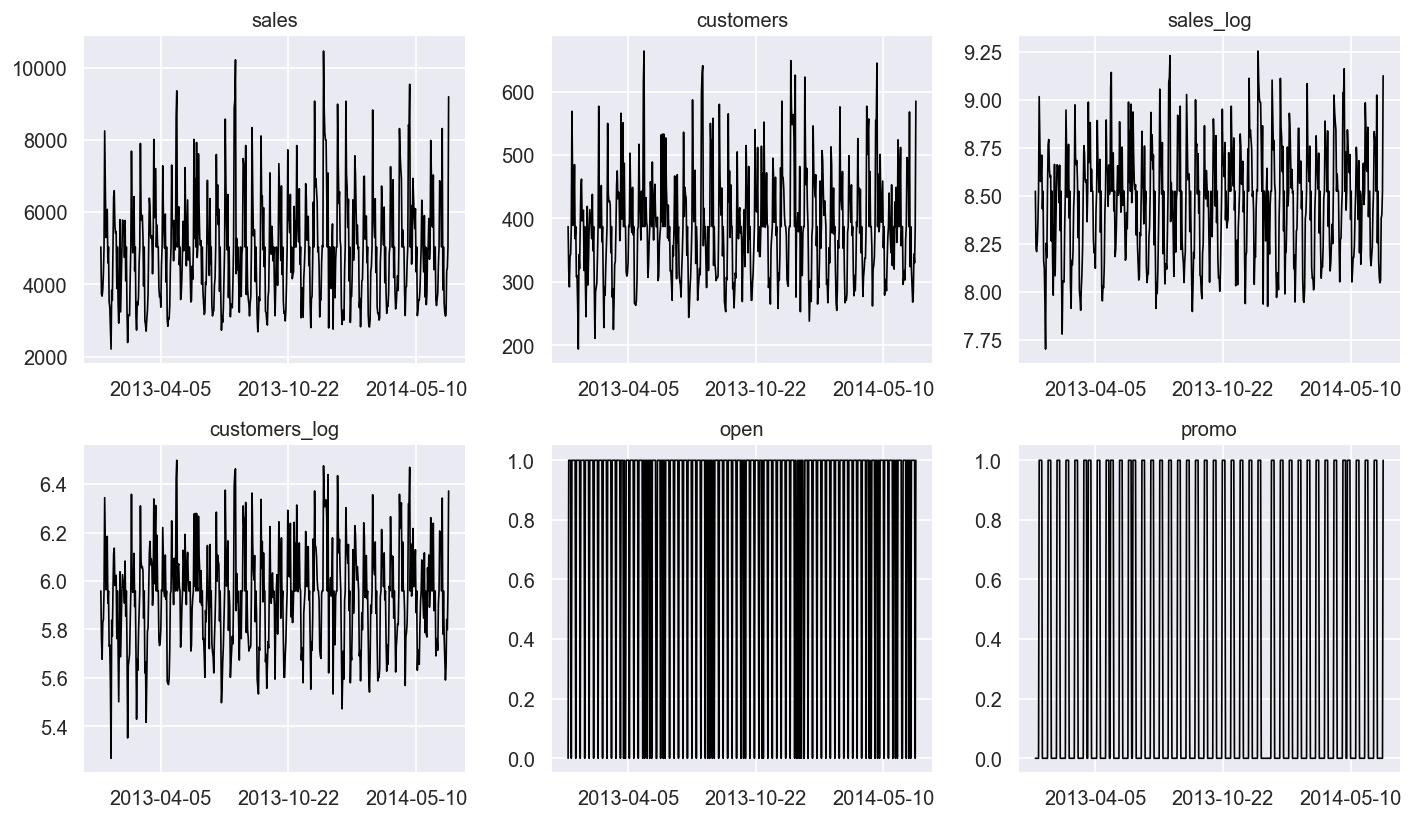

In [144]:
# Plot
ls=['sales','customers','sales_log','customers_log','open','promo','state_holiday','promo2','school_holiday']
df=new_df[ls]
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=120, figsize=(12,7))
for i, ax in enumerate(axes.flatten()):
        ax.plot(df[df.columns[i]], color='black', linewidth=1)
        ax.xaxis.set_major_locator(plt.MaxNLocator(3))
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=12)

plt.tight_layout();

In [145]:
new_df.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'promo2', 'sales_log',
       'ar_forecast_Log', 'arima_forecast', 'customers_log'],
      dtype='object')

In [146]:
new_df1=new_df[['sales_log', 'customers_log']]
new_df1

,sales_log,customers_log
date,,
2013-01-01,8.524119,5.958812
2013-01-02,8.226038,5.758902
2013-01-03,8.209036,5.676754
2013-01-04,8.255309,5.828946
2013-01-05,8.362876,5.840642
...,...,...
2014-06-26,8.059908,5.645447
2014-06-27,8.383890,5.840642
2014-06-28,8.401782,5.799093


In [147]:
#Let's create a model
model = VAR(new_df1)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -9.04590716830437
BIC :  -8.998559067812662
FPE :  0.00011787250945712593
HQIC:  -9.027396907278364 

Lag Order = 2
AIC :  -9.048814587201607
BIC :  -8.969789784869697
FPE :  0.00011753039794980449
HQIC:  -9.017918159507719 

Lag Order = 3
AIC :  -9.112626541522767
BIC :  -9.001835509332942
FPE :  0.00011026503459306327
HQIC:  -9.069306947931949 

Lag Order = 4
AIC :  -9.156060233506855
BIC :  -9.01341302312694
FPE :  0.00010557867717845991
HQIC:  -9.100280297689016 

Lag Order = 5
AIC :  -9.258908675713613
BIC :  -9.08431491576052
FPE :  9.526029507576106e-05
HQIC:  -9.190631043077191 



In [148]:
x = model.select_order(maxlags=5)
x.summary()

,AIC,BIC,FPE,HQIC
0,-8.583,-8.567,0.0001872,-8.577
1,-9.042,-8.994,0.0001184,-9.023
2,-9.045,-8.966,0.0001180,-9.014
3,-9.107,-8.996,0.0001109,-9.063
4,-9.153,-9.010,0.0001059,-9.097
5,-9.259*,-9.084*,9.526e-05*,-9.191*


In [149]:
#Let's fit the model
model_fitted = model.fit()
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Jan, 2022
Time:                     13:10:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.99856
Nobs:                     545.000    HQIC:                  -9.02740
Log likelihood:           924.367    FPE:                0.000117873
AIC:                     -9.04591    Det(Omega_mle):     0.000116585
--------------------------------------------------------------------
Results for equation sales_log
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    3.288754         0.288901           11.384           0.000
L1.sales_log             1.050155         0.150756            6.966           0.000
L1.customers_log        -0.625411         0.

In [150]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

1


In [151]:
# Input data for forecasting
forecast_input = new_df1.values[-lag_order:]
forecast_input

array([[9.12608882, 6.37161185]])

In [164]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=100)
df_forecast = pd.DataFrame(fc, index=new_df.index[-100:], columns=new_df1.columns + '_2d')
df_forecast

,sales_log_2d,customers_log_2d
date,,
2014-03-23,8.887686,6.232920
2014-03-24,8.724065,6.116818
2014-03-25,8.624849,6.046247
2014-03-26,8.564792,6.003529
2014-03-27,8.528440,5.977671
...,...,...
2014-06-26,8.472694,5.938018
2014-06-27,8.472694,5.938018
2014-06-28,8.472694,5.938018


In [165]:
df_forecast['VAR_forecast_Sales'] = np.exp(df_forecast['sales_log_2d'])
df_forecast['VAR_forecast_customers'] = np.exp(df_forecast['customers_log_2d'])
df_forecast

,sales_log_2d,customers_log_2d,VAR_forecast_Sales,VAR_forecast_customers
date,,,,
2014-03-23,8.887686,6.232920,7242.238246,509.240201
2014-03-24,8.724065,6.116818,6149.123002,453.419779
2014-03-25,8.624849,6.046247,5568.319756,422.524510
2014-03-26,8.564792,6.003529,5243.749831,404.854864
2014-03-27,8.528440,5.977671,5056.553123,394.520540
...,...,...,...,...
2014-06-26,8.472694,5.938018,4782.381124,379.182690
2014-06-27,8.472694,5.938018,4782.381124,379.182690
2014-06-28,8.472694,5.938018,4782.381124,379.182690


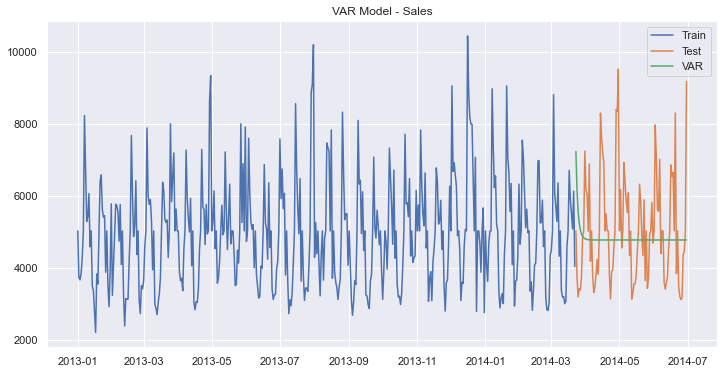

In [166]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(df_forecast['VAR_forecast_Sales'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - Sales')
plt.show()

In [167]:
train_len = 446
train1 = new_df[0:train_len] # first 890days as training set
test1 = new_df[train_len:] # last 42 days as out-of-time test set

In [168]:
train1

,store,day_of_week,sales,customers,open,promo,state_holiday,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log
date,,,,,,,,,,,,,
2013-01-01,13,2,5034.747182,387.149888,0,0,a,1,1,8.524119,8.472804,4782.907347,5.958812
2013-01-02,13,3,3737.000000,317.000000,1,0,0,1,1,8.226038,8.504157,4935.242128,5.758902
2013-01-03,13,4,3674.000000,292.000000,1,0,0,1,1,8.209036,8.344777,4208.145517,5.676754
2013-01-04,13,5,3848.000000,340.000000,1,0,0,1,1,8.255309,8.251208,3832.251371,5.828946
2013-01-05,13,6,4285.000000,344.000000,1,0,0,0,1,8.362876,8.299682,4022.594208,5.840642
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-18,13,2,5898.000000,429.000000,1,1,0,0,1,8.682369,8.779264,6498.091235,6.061457
2014-03-19,13,3,5530.000000,432.000000,1,1,0,0,1,8.617943,8.837082,6884.873852,6.068426
2014-03-20,13,4,5090.000000,394.000000,1,1,0,0,1,8.535033,8.654483,5735.800654,5.976351


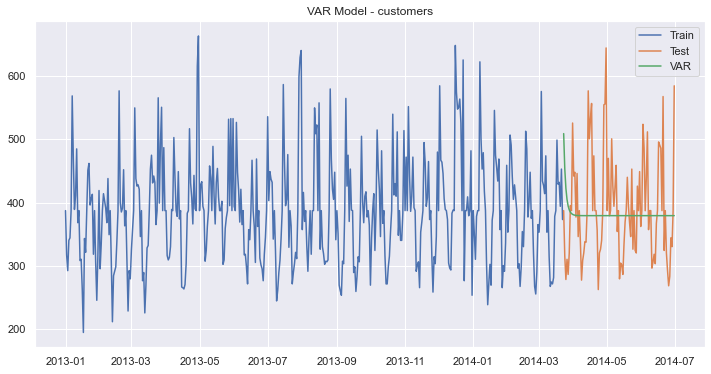

In [169]:
plt.figure(figsize=(12,6)) 
plt.plot(train1['customers'], label='Train')
plt.plot(test1['customers'], label='Test')
plt.plot(df_forecast['VAR_forecast_customers'], label='VAR')
plt.legend(loc='best')
plt.title('VAR Model - customers')
plt.show()

**Model evalution**

In [170]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test1['sales'], df_forecast['VAR_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test1['sales']-df_forecast['VAR_forecast_Sales'])/test1['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VAR'], 'RMSE': [rmse],'MAPE': [mape] })

In [171]:
tempResults

,Method,RMSE,MAPE
0,VAR,1565.18,23.6


In [172]:
results = pd.concat([Results , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1081.61,14.95
0,VAR,1565.18,23.60


**Johansen-Impulse**

In [174]:
joh_model1 = coint_johansen(new_df[['sales','customers']],-1,1)

In [175]:
joh_model1

In [176]:
joh_model1.lr2

array([99.26498561,  1.34566343])

In [177]:
joh_model1.lr1

array([100.61064904,   1.34566343])

In [178]:
new_df[['sales','customers']].shape

(546, 2)

In [179]:
def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

In [180]:
joh_output(joh_model1)

   max_eig_stat  trace_stat
0     99.264986  100.610649
1      1.345663    1.345663 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



In [181]:
from statsmodels.tsa.vector_ar.vecm import select_coint_rank

In [183]:
rank=select_coint_rank(new_df[['sales','customers']],-1,1)
print(rank.rank)

1


**Rank is one**

In [185]:
from statsmodels.tsa.stattools import coint

In [186]:
coint(new_df['sales'],new_df['customers'])#null hypothesis-There is not coint

(-5.41457741290247,
 2.653951142044937e-05,
 array([-3.91664811, -3.34736416, -3.05224118]))

2.653951142044937e-05<.05

We can reject the null hypothesis

**Sales and customers are cointegration to each other**

**VARMAX MODEL**

In [188]:
#create dymmy variables
new_df=pd.get_dummies(new_df)
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,13,2,5034.747182,387.149888,0,0,1,1,8.524119,8.472804,4782.907347,5.958812,0,1,0,0
2013-01-02,13,3,3737.000000,317.000000,1,0,1,1,8.226038,8.504157,4935.242128,5.758902,1,0,0,0
2013-01-03,13,4,3674.000000,292.000000,1,0,1,1,8.209036,8.344777,4208.145517,5.676754,1,0,0,0
2013-01-04,13,5,3848.000000,340.000000,1,0,1,1,8.255309,8.251208,3832.251371,5.828946,1,0,0,0
2013-01-05,13,6,4285.000000,344.000000,1,0,0,1,8.362876,8.299682,4022.594208,5.840642,1,0,0,0


In [189]:
new_df.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2013-01-01,13,2,5034.747182,387.149888,0,0,1,1,8.524119,8.472804,4782.907347,5.958812,0,1,0,0
2013-01-02,13,3,3737.000000,317.000000,1,0,1,1,8.226038,8.504157,4935.242128,5.758902,1,0,0,0
2013-01-03,13,4,3674.000000,292.000000,1,0,1,1,8.209036,8.344777,4208.145517,5.676754,1,0,0,0
2013-01-04,13,5,3848.000000,340.000000,1,0,1,1,8.255309,8.251208,3832.251371,5.828946,1,0,0,0
2013-01-05,13,6,4285.000000,344.000000,1,0,0,1,8.362876,8.299682,4022.594208,5.840642,1,0,0,0


In [190]:
exog = new_df[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']]
mod = sm.tsa.VARMAX(new_df[['sales_log', 'customers_log']], order=(1,1), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:     ['sales_log', 'customers_log']   No. Observations:                  546
Model:                                VARMAX(1,1)   Log Likelihood                1130.145
Date:                            Sat, 15 Jan 2022   AIC                          -2206.290
Time:                                    13:58:59   BIC                          -2090.120
Sample:                                01-01-2013   HQIC                         -2160.878
                                     - 06-30-2014                                         
Covariance Type:                              opg                                         
Ljung-Box (L1) (Q):             0.88, 0.68   Jarque-Bera (JB):          13.08, 7.32
Prob(Q):                        0.35, 0.41   Prob(JB):                   0.00, 0.03
Heteroskedasticity (H):         1.01, 0.76   Skew:                       0.33, 0.12
Prob(H) (two-sided):

In [191]:
train_len = 446
train = new_df[0:train_len] # first 7500days as training set
test = new_df[train_len:] 

start_index = test.index.min()
end_index = test.index.max()

In [192]:
print(start_index)
print(end_index)

2014-03-23 00:00:00
2014-06-30 00:00:00


In [193]:
test.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,promo2,sales_log,ar_forecast_Log,arima_forecast,customers_log,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
date,,,,,,,,,,,,,,,,
2014-03-23,13,7,5034.747182,387.149888,0,0,0,1,8.524119,8.371932,4323.982058,5.958812,1,0,0,0
2014-03-24,13,1,3737.000000,315.000000,1,0,0,1,8.226038,8.281993,3952.062122,5.752573,1,0,0,0
2014-03-25,13,2,3198.000000,278.000000,1,0,0,1,8.070281,8.293747,3998.789028,5.627621,1,0,0,0
2014-03-26,13,3,3425.000000,310.000000,1,0,0,1,8.138857,8.133083,3405.282190,5.736572,1,0,0,0
2014-03-27,13,4,3391.000000,286.000000,1,0,0,1,8.128880,8.274587,3922.903926,5.655992,1,0,0,0


In [194]:
predictions = mod.fit().predict(start=start_index, end=end_index, exog=test[['open','promo','school_holiday','promo2','state_holiday_0','state_holiday_a','state_holiday_b','state_holiday_c']])

In [195]:
predictions

,sales_log,customers_log
2014-03-23,8.483292,5.935654
2014-03-24,8.296820,5.822491
2014-03-25,8.210780,5.760370
2014-03-26,8.167979,5.729071
2014-03-27,8.183326,5.741016
...,...,...
2014-06-26,8.165114,5.725820
2014-06-27,8.163521,5.726153
2014-06-28,8.268594,5.797820
2014-06-29,8.541457,5.968861


In [196]:
predictions['VARMAX_forecast_Sales'] = np.exp(predictions['sales_log'])
predictions['VARMAX_forecast_customers'] = np.exp(predictions['customers_log'])
predictions

,sales_log,customers_log,VARMAX_forecast_Sales,VARMAX_forecast_customers
2014-03-23,8.483292,5.935654,4833.335160,378.287143
2014-03-24,8.296820,5.822491,4011.098714,337.812628
2014-03-25,8.210780,5.760370,3680.412485,317.465816
2014-03-26,8.167979,5.729071,3526.209185,307.683259
2014-03-27,8.183326,5.741016,3580.746140,311.380649
...,...,...,...,...
2014-06-26,8.165114,5.725820,3516.121417,306.684771
2014-06-27,8.163521,5.726153,3510.526804,306.786742
2014-06-28,8.268594,5.797820,3899.460898,329.580309
2014-06-29,8.541457,5.968861,5122.801394,391.059860


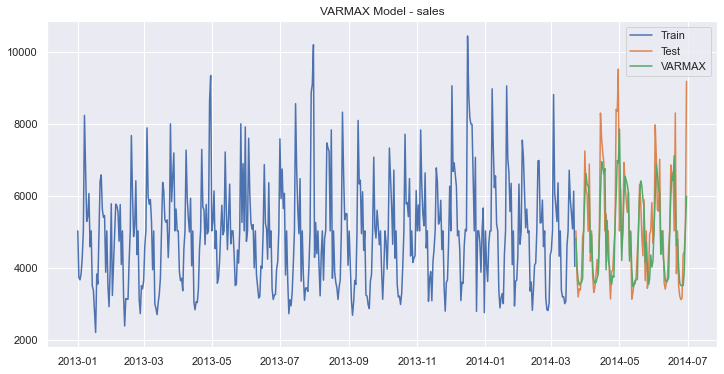

In [197]:
plt.figure(figsize=(12,6)) 
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(predictions['VARMAX_forecast_Sales'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

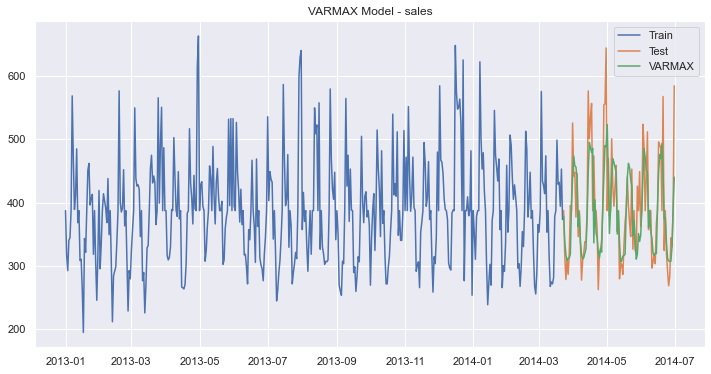

In [198]:
plt.figure(figsize=(12,6)) 
plt.plot(train['customers'], label='Train')
plt.plot(test['customers'], label='Test')
plt.plot(predictions['VARMAX_forecast_customers'], label='VARMAX')
plt.legend(loc='best')
plt.title('VARMAX Model - sales')
plt.show()

**Model Evalution**

In [199]:
# Let's calculate the rmse and MAPE
rmse = np.sqrt(mean_squared_error(test['sales'], predictions['VARMAX_forecast_Sales'])).round(2)
mape = np.round(np.mean(np.abs(test['sales']-predictions['VARMAX_forecast_Sales'])/test['sales'])*100,2)
tempResults = pd.DataFrame({'Method':['VARMAX'], 'RMSE': [rmse],'MAPE': [mape] })

In [200]:
results = pd.concat([results  , tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,ARIMA,1081.61,14.95
0,VAR,1565.18,23.60
0,VARMAX,937.49,11.78


**VARMAX is the best model**

-  Is the sales data non-stationary? If so, how do you find it and correct it?

-  Is the data cointegrated? Which variables are cointegrated and how do you find them?

-  What is the impact of the number of customers on sales?

-  What is the impact of promo and promo2 variables on sales? How do you measure it?

-  **Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE**

-   Find outliers at the 99th percentile and remove them.

-   Standardize the sales and number of customers variables before modelling.

-   Determine if the data is stationary

-   If stationary then apply Vector Autoregression Model.

-   If non-stationary then specify the model in differences

-   Make sales, promo2 and any other variables you think of as dependent variables.

-   check for cointegration using the Johansen test. 

-   **Predict sales for the next 6 weeks**

# Conclusion



-   The data is stationary
-   Sales and Customers are cointegrated to each others
-   Sales will get increase as the number of customer will get increase.
-   promo has positive impact on sales
-   promo2 doesn't have any impact on sales